<a href="https://colab.research.google.com/github/leohcar/ESPACIOINF/blob/master/Aula_5_Exerc%C3%ADcio_Carlos_Ancasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
nome = "Carlos Leonardo Ancasi Hinostroza"
print(f'Meu nome é {nome}')

Meu nome é Carlos Leonardo Ancasi Hinostroza


Este exercicío consiste em treinar no MNIST um modelo de umas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [154]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [155]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [156]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [157]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [158]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [159]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [160]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

In [161]:
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'
        # Escreva seu código aqui.
        y_height = ( x.shape[3] - self.kernel_size) // self.stride + 1
        y_width = ( x.shape[2] - self.kernel_size) // self.stride + 1
        
        out = torch.zeros((x.shape[0], self.out_channels, y_width, y_height))

        for i in range(self.in_channels):
            for j in range(self.out_channels):
                for k_o, k_i in enumerate(range(0,x.shape[3] - self.kernel_size+1,self.stride)):
                    for l_o, l_i in enumerate(range(0,x.shape[2] - self.kernel_size+1,self.stride)):
                        window = x[:, i, l_i:l_i+self.kernel_size, k_i:k_i+self.kernel_size]
                        out[:, j, l_o, k_o] = (self.weight[j, i, :, :] * window).sum(dim=-1).sum(dim=-1).squeeze() + self.bias[j]

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [162]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
target_out = pytorch_conv_layer(x)
print(out)
print(target_out)

assert torch.allclose(out, target_out, atol=1e-6)

tensor([[[[ 34.,  40.,  46.,  52.,  58.],
          [ 70.,  76.,  82.,  88.,  94.],
          [106., 112., 118., 124., 130.],
          [142., 148., 154., 160., 166.]]]])
tensor([[[[ 34.,  40.,  46.,  52.,  58.],
          [ 70.,  76.,  82.,  88.,  94.],
          [106., 112., 118., 124., 130.],
          [142., 148., 154., 160., 166.]]]], grad_fn=<ConvolutionBackward0>)


## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [163]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
target_out = pytorch_conv_layer(x)
print(out.size())
print(target_out.size())

assert torch.allclose(out, target_out, atol=1e-6)

torch.Size([2, 2, 8, 8])
torch.Size([2, 2, 8, 8])


## Modelo

In [164]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [165]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [166]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 2.303267478942871
Epoch: 1/49 Loss: 2.227701187133789
Epoch: 2/49 Loss: 1.0923893451690674
Epoch: 3/49 Loss: 0.5867354273796082
Epoch: 4/49 Loss: 0.5144088864326477
Epoch: 5/49 Loss: 0.45026639103889465
Epoch: 6/49 Loss: 0.4075140655040741
Epoch: 7/49 Loss: 0.37713873386383057
Epoch: 8/49 Loss: 0.3534485995769501
Epoch: 9/49 Loss: 0.334145188331604
Epoch: 10/49 Loss: 0.31811410188674927
Epoch: 11/49 Loss: 0.30457887053489685
Epoch: 12/49 Loss: 0.29283493757247925
Epoch: 13/49 Loss: 0.2827608287334442
Epoch: 14/49 Loss: 0.2738332450389862
Epoch: 15/49 Loss: 0.26577430963516235
Epoch: 16/49 Loss: 0.2583288550376892
Epoch: 17/49 Loss: 0.25117501616477966
Epoch: 18/49 Loss: 0.24439717829227448
Epoch: 19/49 Loss: 0.23789972066879272
Epoch: 20/49 Loss: 0.23167714476585388
Epoch: 21/49 Loss: 0.2256263792514801
Epoch: 22/49 Loss: 0.21984544396400452
Epoch: 23/49 Loss: 0.21429124474525452
Epoch: 24/49 Loss: 0.20894232392311096
Epoch: 25/49 Loss: 0.20387302339076996
Epoch: 26/4

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

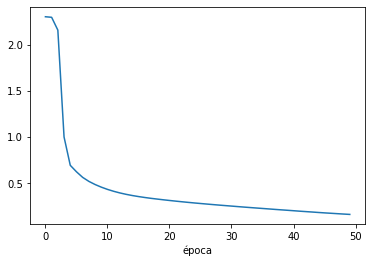

In [167]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [168]:
loss_epoch_end

[2.303267478942871,
 2.227701187133789,
 1.0923893451690674,
 0.5867354273796082,
 0.5144088864326477,
 0.45026639103889465,
 0.4075140655040741,
 0.37713873386383057,
 0.3534485995769501,
 0.334145188331604,
 0.31811410188674927,
 0.30457887053489685,
 0.29283493757247925,
 0.2827608287334442,
 0.2738332450389862,
 0.26577430963516235,
 0.2583288550376892,
 0.25117501616477966,
 0.24439717829227448,
 0.23789972066879272,
 0.23167714476585388,
 0.2256263792514801,
 0.21984544396400452,
 0.21429124474525452,
 0.20894232392311096,
 0.20387302339076996,
 0.1990342140197754,
 0.1943996101617813,
 0.18994112312793732,
 0.18563991785049438,
 0.181474968791008,
 0.17744915187358856,
 0.17347261309623718,
 0.1694747358560562,
 0.1654733121395111,
 0.16150504350662231,
 0.1574639081954956,
 0.15340447425842285,
 0.14926929771900177,
 0.14520640671253204,
 0.14123660326004028,
 0.13712672889232635,
 0.13310375809669495,
 0.12914669513702393,
 0.1251506507396698,
 0.12116782367229462,
 0.11731723

In [169]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)